In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Data 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"
basis = "6-311++g**"

data = Data()
data.include(data_path = "../../thesis/dataset/EthanT/", postfix = "EthanT", target=target)

In [4]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

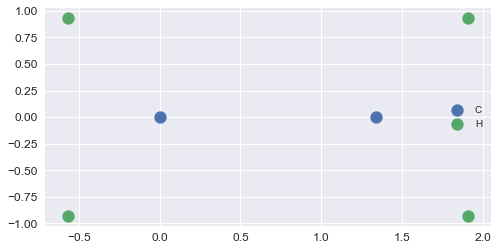

In [5]:
#%matplotlib inline

pos = np.array(mol.positions)

plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

# Descriptor 

In [6]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    SphereSectionDescriptor, ConstantAngularDescriptor, Gaussians
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(8, R_c=3.5, R_min=1.0, eta_max=100)#, eta_min=80)

radial = Gaussians(*model)

descriptor = AtomicNumberWeighted(
    ConstantAngularDescriptor(),
    SphereSectionDescriptor(
        number_azimuthal_sections=8,
        number_polar_sections=4,
        radial_descriptor=radial
    ),
    BehlerCutoff1(5)
)
    

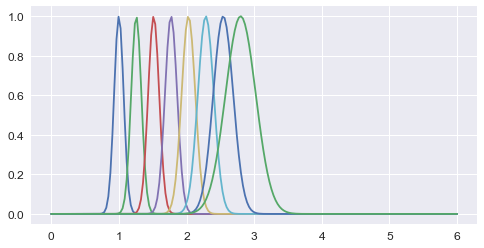

In [7]:
from SCFInitialGuess.descriptors.utilities import plot_normal_model

#%matplotlib inline

plot_normal_model(model, np.linspace(0, 6, 200))

# Calculate Dataset for C

In [8]:
G = descriptor.calculate_atom_descriptor(
    index_atom=1, 
    molecule=mol, 
    number_of_descriptors=descriptor.number_of_descriptors
)

<Container object of 256 artists>

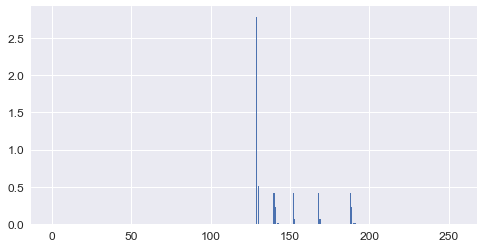

In [9]:
plt.bar(np.arange(len(G)), G)

# Activation 

In [10]:
n = 100

r = np.linspace(0, 6, n)
phi = np.linspace(0, 2*np.pi, n)
theta = np.pi/2

R, Phi = np.meshgrid(r, phi)

R = R.reshape(-1)
Phi = Phi.reshape(-1)

## Radial 

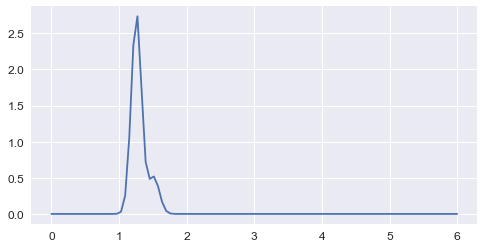

In [11]:
plt.plot(r, descriptor.angular_descriptor.calculate_inverse_descriptor(r, phi=0.0, theta=np.pi/2, y=G).reshape(-1))

## Angles, z=0

In [12]:
R.shape, Phi.shape

((10000,), (10000,))

In [13]:
z = descriptor.angular_descriptor.calculate_inverse_descriptor(
    r=r, 
    phi=phi, 
    theta=theta, 
    y=G
)#.reshape(-1)

z[z==0] = 1e-20

z.shape

(1, 100, 100)

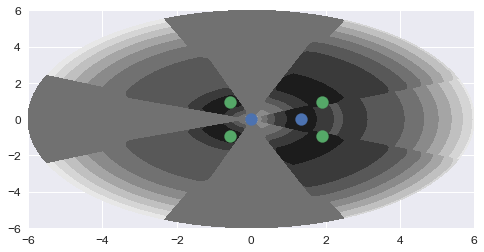

In [14]:
plt.contourf(
    (R * np.cos(Phi)).reshape(n, n),
    (R * np.sin(Phi)).reshape(n, n),
    z.reshape(n, n),
    locator=mpl.ticker.LogLocator()
)

plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")


## Angles, Spheres 

In [15]:
n = 100

r = 2
phi = np.linspace(0, 2*np.pi, n)
theta = np.linspace(0, np.pi, n)

Phi, Theta = np.meshgrid(phi, theta)

In [16]:
z = descriptor.angular_descriptor.calculate_inverse_descriptor(
    r=r, 
    phi=phi, 
    theta=theta, 
    y=G
)#.reshape(-1)

z[z==0] = 1e-20

z.shape

(100, 100, 1)

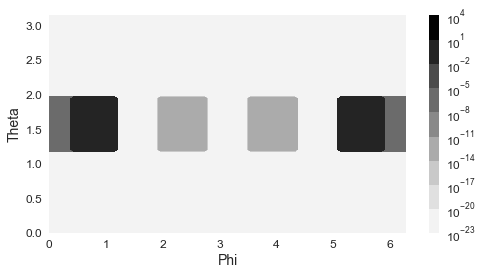

In [17]:
plt.contourf(
    Phi, 
    Theta,
    z.reshape(n, n),
    locator=mpl.ticker.LogLocator()
)
plt.xlabel("Phi")
plt.ylabel("Theta")
plt.colorbar()

In [18]:
#%matplotlib notebook

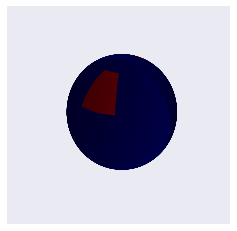

In [19]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

fcolors = z.reshape(n,n)
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

x = np.sin(Phi) * np.cos(Theta)
y = np.sin(Phi) * np.sin(Theta)
z = np.cos(Phi)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    x, 
    y, 
    z,  
    rstride=1, 
    cstride=1, 
    facecolors=cm.seismic(fcolors)
)
# Turn off the axis planes
ax.set_axis_off()
plt.show()

# Calculate The Dataset 

In [20]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset

dataset = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C"
)

In [21]:
dataset.testing[0][0].shape, dataset.testing[1].shape

((256,), (402, 253))

# Visualize The Descriptor 

In [22]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset.training[0], dataset.x_mean, dataset.x_std)
y_train = dataset.training[1]
np.mean(x_train[0] - x_train[-1])

-0.00227969412752458

## Varaince

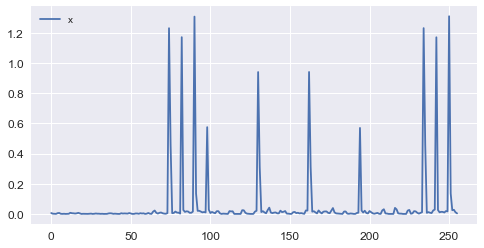

In [23]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
#plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

## Average 

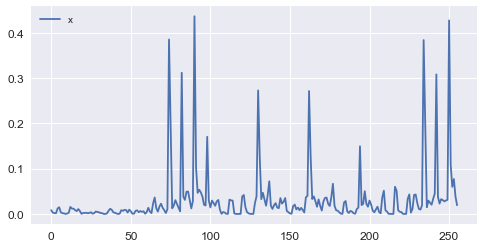

In [24]:
plt.plot(np.mean(x_train, 0), label="x")
#plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

## PCA 

### Input 

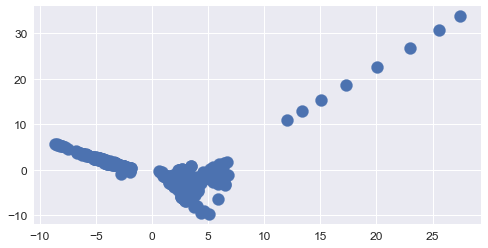

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dataset.testing[0])

x = pca.transform(dataset.testing[0])

plt.scatter(x[:,0], x[:, 1])

### Output 

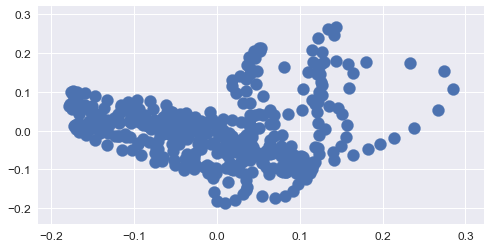

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dataset.testing[1])

x = pca.transform(dataset.testing[1])

plt.scatter(x[:,0], x[:, 1])

# Try to Learn

## Utils 

In [ ]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [ ]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

## Setup network 

In [ ]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

In [ ]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "C"

dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2

descriptor.number_of_descriptors, dim_triu

In [ ]:
keras.backend.clear_session()

In [ ]:
structure = [descriptor.number_of_descriptors, dim_triu, dim_triu]

model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_triu,
    
)

model.summary()

## Train network 

In [ ]:
#i+=1
train_model(
    model, 
    dataset, 
    None,#model_path + name_folder,
    learning_rate=1e-4,
    log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)